# Extracion 

In [81]:
# ============================================================
# TELECOM X — PIPELINE COMPLETO (ETL + EDA + INFORME)
# ============================================================

# 0) IMPORTS
import re
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt

# -----------------------------
# Configuración de impresión
pd.set_option("display.max_columns", 100)

URL = "https://raw.githubusercontent.com/ingridcristh/challenge2-data-science-LATAM/main/TelecomX_Data.json"

data = requests.get(URL).json()
df = pd.json_normalize(data)
df_raw = df.copy()


# Normalizacion

In [82]:

def norm_str(x):
    if isinstance(x, str):
        x = x.strip()
        x = re.sub(r"\s+", " ", x)
        x = x.lower()
    return x

for c in df.columns:
    if df[c].dtype == "object":
        df[c] = df[c].map(norm_str)


# Estandarizacion

In [83]:
def ensure_col(df, target, candidates):
    """
    Si 'target' no existe, busca el primer candidato existente (case-insensitive).
    Si lo encuentra, renombra al nombre estándar 'target'.
    """
    if target in df.columns:
        return True
    lower_cols = {c.lower(): c for c in df.columns}
    for cand in candidates:
        if cand.lower() in lower_cols:
            df.rename(columns={lower_cols[cand.lower()]: target}, inplace=True)
            return True
    return False

# Cargos y métricas clave
ensure_col(df, "cargo_total",
           ["account.Charges.Total", "account.charges.total", "TotalCharges",
            "totalcharges", "total_charges", "charges_total"])
ensure_col(df, "cargo_mensual",
           ["account.Charges.Monthly", "account.charges.monthly", "MonthlyCharges",
            "monthlycharges", "monthly_charges", "charges_monthly"])
ensure_col(df, "meses_tenencia",
           ["customer.tenure", "customer.tenure".lower(), "tenure"])
ensure_col(df, "churn",
           ["Churn", "churn"])

# Categóricas clave
ensure_col(df, "contrato",
           ["account.Contract", "account.contract", "Contract", "contract"])
ensure_col(df, "metodo_pago",
           ["account.PaymentMethod", "account.paymentmethod", "PaymentMethod", "paymentmethod"])
ensure_col(df, "genero",
           ["customer.gender", "customer.gender".lower(), "gender"])

# Servicios (para reglas de coherencia)
ensure_col(df, "telefono_servicio",
           ["phone.PhoneService", "phone.phoneservice"])
ensure_col(df, "telefono_lineas_multiples",
           ["phone.MultipleLines", "phone.multiplelines"])
ensure_col(df, "internet_servicio",
           ["internet.InternetService", "internet.internetservice"])
ensure_col(df, "internet_seguridad",
           ["internet.OnlineSecurity", "internet.onlinesecurity"])
ensure_col(df, "internet_respaldo",
           ["internet.OnlineBackup", "internet.onlinebackup"])
ensure_col(df, "internet_proteccion",
           ["internet.DeviceProtection", "internet.deviceprotection"])
ensure_col(df, "internet_soporte",
           ["internet.TechSupport", "internet.techsupport"])
ensure_col(df, "internet_tv",
           ["internet.StreamingTV", "internet.streamingtv"])
ensure_col(df, "internet_peliculas",
           ["internet.StreamingMovies", "internet.streamingmovies"])
ensure_col(df, "facturacion_electronica",
           ["account.PaperlessBilling", "account.paperlessbilling"])

# Verificación dura para evitar errores posteriores
missing_required = [c for c in ["cargo_total", "cargo_mensual", "meses_tenencia", "churn"] if c not in df.columns]
if missing_required:
    raise KeyError(f"Faltan columnas requeridas: {missing_required}\nColumnas disponibles: {list(df.columns)}")

# Conversiones

In [84]:
def to_number(col):
    col = col.astype(str).str.replace(r"[\$,]", "", regex=True).str.strip()
    col = col.replace({"": np.nan, "nan": np.nan})
    return pd.to_numeric(col, errors="coerce")

df["cargo_total"]   = to_number(df["cargo_total"])
df["cargo_mensual"] = to_number(df["cargo_mensual"])
df["meses_tenencia"] = pd.to_numeric(df["meses_tenencia"], errors="coerce").fillna(0).astype(int)

# Mapeo robusto Sí/No a 1/0 para columnas binarias
map_si_no = {"yes":1, "no":0, "si":1, "sí":1, "true":1, "false":0, "1":1, "0":0}

yes_no_like_cols = [
    "churn", "facturacion_electronica", "telefono_servicio", "telefono_lineas_multiples",
    "internet_seguridad", "internet_respaldo", "internet_proteccion",
    "internet_soporte", "internet_tv", "internet_peliculas"
]
for c in yes_no_like_cols:
    if c in df.columns:
        s = df[c].astype(str).str.strip().str.lower().map(map_si_no)
        s = pd.to_numeric(s, errors="coerce").fillna(0).astype(int)
        df[c] = s

# internet_servicio es categórica: "dsl", "fiber optic", "no", etc.
# Creamos bandera de internet activo: 0 si "no" o "no internet service"; 1 en otro caso.
df["internet_activo"] = np.where(df["internet_servicio"].isin(["no", "no internet service"]), 0, 1).astype(int)

# Si no hay internet, forzar addons a 0
internet_addons = ["internet_seguridad", "internet_respaldo", "internet_proteccion",
                   "internet_soporte", "internet_tv", "internet_peliculas"]
for c in internet_addons:
    if c in df.columns:
        df[c] = np.where(df["internet_activo"] == 0, 0, df[c])

# Teléfono activo: ya tenemos telefono_servicio binario (1/0)
df["telefono_activo"] = df["telefono_servicio"]
# Si no hay teléfono, líneas múltiples = 0
if "telefono_lineas_multiples" in df.columns:
    df["telefono_lineas_multiples"] = np.where(df["telefono_activo"] == 0, 0, df["telefono_lineas_multiples"])

# Renombramiento

In [85]:
rename_map = {
    "customerID": "cliente_id",

}
df.rename(columns=rename_map, inplace=True)
if "cliente_id" not in df.columns and "customerID" in df.columns:
    df.rename(columns={"customerID": "cliente_id"}, inplace=True)

df["cuentas_diarias"] = (df["cargo_mensual"] / 30.0).replace([np.inf, -np.inf], np.nan).fillna(0)
servicios_binarios = ["telefono_activo", "telefono_lineas_multiples", "internet_activo"] + [c for c in internet_addons if c in df.columns]
servicios_binarios = [c for c in servicios_binarios if c in df.columns]
df["servicios_contratados"] = df[servicios_binarios].sum(axis=1)
df["gasto_estimado"] = df["cargo_mensual"] * df["meses_tenencia"]


print("=== Dimensiones ===", df.shape)
print("\n=== Nulos por columna ===\n", df.isna().sum())
print("\n=== Tipos de datos ===\n", df.dtypes)

cat_preview = ["genero", "internet_servicio", "contrato", "metodo_pago"]
print("\n=== Valores únicos (muestra) de categóricas ===")
for c in cat_preview:
    if c in df.columns:
        print(f"- {c}: {df[c].dropna().unique()[:10]}")

print("\n=== Estadísticas numéricas ===\n", df[[
    "cargo_mensual", "cargo_total", "meses_tenencia",
    "cuentas_diarias", "servicios_contratados"
]].describe())


=== Dimensiones === (7267, 26)

=== Nulos por columna ===
 cliente_id                    0
churn                         0
genero                        0
customer.SeniorCitizen        0
customer.Partner              0
customer.Dependents           0
meses_tenencia                0
telefono_servicio             0
telefono_lineas_multiples     0
internet_servicio             0
internet_seguridad            0
internet_respaldo             0
internet_proteccion           0
internet_soporte              0
internet_tv                   0
internet_peliculas            0
contrato                      0
facturacion_electronica       0
metodo_pago                   0
cargo_mensual                 0
cargo_total                  11
internet_activo               0
telefono_activo               0
cuentas_diarias               0
servicios_contratados         0
gasto_estimado                0
dtype: int64

=== Tipos de datos ===
 cliente_id                    object
churn                          int

# Chequeos de Incoherencias

In [86]:
incoherencias = {}
incoherencias["tenencia_negativa"] = df[df["meses_tenencia"] < 0]
incoherencias["cargo_mensual_negativo"] = df[df["cargo_mensual"] < 0]
incoherencias["cargo_total_negativo"] = df[df["cargo_total"] < 0]
incoherencias["tenencia0_totalpos"] = df[(df["meses_tenencia"] == 0) & (df["cargo_total"] > 0)]

expected = df["gasto_estimado"].copy()
delta = (df["cargo_total"] - expected).abs()
incoherencias["cargos_desproporcionados_20pct"] = df[(expected > 0) & (delta > 0.2 * expected)]

if "telefono_lineas_multiples" in df.columns:
    incoherencias["lineas_sin_telefono"] = df[(df["telefono_activo"] == 0) & (df["telefono_lineas_multiples"] == 1)]
if len(internet_addons) > 0:
    addons_sum = df[[c for c in internet_addons if c in df.columns]].sum(axis=1)
    incoherencias["addons_sin_internet"] = df[(df["internet_activo"] == 0) & (addons_sum > 0)]

print("\n=== Resumen incoherencias ===")
for k, v in incoherencias.items():
    print(f"{k}: {len(v)}")



=== Resumen incoherencias ===
tenencia_negativa: 0
cargo_mensual_negativo: 0
cargo_total_negativo: 0
tenencia0_totalpos: 0
cargos_desproporcionados_20pct: 64
lineas_sin_telefono: 0
addons_sin_internet: 0


# CHURN Y DISTRIBUCIONES

In [87]:

# Asegurar churn 1/0
df["churn"] = pd.to_numeric(df["churn"], errors="coerce").fillna(0).astype(int)

total_clientes = len(df)
total_churn = df["churn"].sum()
pct_churn = round(total_churn / total_clientes * 100, 2)

def pct_series(s):
    return s.mean() * 100

churn_por_contrato = df.groupby("contrato")["churn"].apply(pct_series).round(2).sort_values(ascending=False) if "contrato" in df.columns else pd.Series(dtype=float)
churn_por_pago     = df.groupby("metodo_pago")["churn"].apply(pct_series).round(2).sort_values(ascending=False) if "metodo_pago" in df.columns else pd.Series(dtype=float)
churn_por_genero   = df.groupby("genero")["churn"].apply(pct_series).round(2) if "genero" in df.columns else pd.Series(dtype=float)

print("\n=== Churn global y por categorías ===")
print(f"Clientes: {total_clientes} | Churn: {total_churn} ({pct_churn}%)")
if not churn_por_contrato.empty: print("\nChurn por contrato:\n", churn_por_contrato)
if not churn_por_pago.empty:     print("\nChurn por método de pago:\n", churn_por_pago)
if not churn_por_genero.empty:   print("\nChurn por género:\n", churn_por_genero)


=== Churn global y por categorías ===
Clientes: 7267 | Churn: 1869 (25.72%)

Churn por contrato:
 contrato
month-to-month    41.32
one year          10.93
two year           2.75
Name: churn, dtype: float64

Churn por método de pago:
 metodo_pago
electronic check             43.80
mailed check                 18.50
bank transfer (automatic)    16.24
credit card (automatic)      14.80
Name: churn, dtype: float64

Churn por género:
 genero
female    26.14
male      25.31
Name: churn, dtype: float64


# Correlaciones


=== Correlaciones con churn (desc) ===
 churn                        1.000000
internet_activo              0.224051
cuentas_diarias              0.189866
cargo_mensual                0.189866
internet_tv                  0.062430
internet_peliculas           0.060586
telefono_lineas_multiples    0.039343
telefono_activo              0.012571
servicios_contratados       -0.017673
internet_proteccion         -0.063452
internet_respaldo           -0.080163
internet_soporte            -0.160440
internet_seguridad          -0.166828
cargo_total                 -0.194440
meses_tenencia              -0.344079
Name: churn, dtype: float64


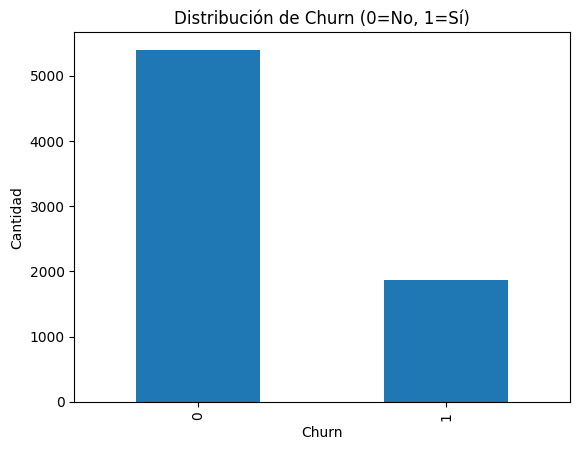

In [88]:

num_cols = [
    "churn", "meses_tenencia", "cargo_mensual", "cargo_total",
    "cuentas_diarias", "servicios_contratados",
    "telefono_activo"
] + [c for c in ["telefono_lineas_multiples","internet_activo"] if c in df.columns] \
  + [c for c in internet_addons if c in df.columns]

num_cols = [c for c in num_cols if c in df.columns]
corr = df[num_cols].corr()
corr_con_churn = corr["churn"].sort_values(ascending=False)
print("\n=== Correlaciones con churn (desc) ===\n", corr_con_churn)

# (Gráfico simple opcional: histograma churn)
plt.figure()
df["churn"].value_counts().sort_index().plot(kind="bar")
plt.title("Distribución de Churn (0=No, 1=Sí)")
plt.xlabel("Churn")
plt.ylabel("Cantidad")
plt.show()


# INFORME FINAL

In [89]:

incoh_lines = []
for k, v in incoherencias.items():
    incoh_lines.append(f"- {k.replace('_', ' ')}: {len(v)} registros")
incoh_block = "\n".join(incoh_lines) if incoh_lines else "- Sin incoherencias detectadas"

def series_to_md(s, titulo):
    if s is None or s.empty:
        return f"\n### {titulo}\n- (No disponible)\n"
    out = f"\n### {titulo}\n"
    for idx, val in s.items():
        out += f"- {idx}: {val}%\n"
    return out

top_corr = corr_con_churn.drop("churn", errors="ignore").head(5)
top_corr_block = "\n".join([f"- {var}: {round(val,3)}" for var, val in top_corr.items()]) if not top_corr.empty else "- (No disponible)"

informe_md = f"""
# 📌 Informe Final — Challenge Telecom X

## 1️⃣ Introducción
Se analizaron **{total_clientes} clientes**, con **{total_churn}** casos de churn (**{pct_churn}%**).

**Objetivos**:
- Asegurar calidad de datos (limpieza, estandarización).
- Crear variables derivadas y preparar el dataset.
- Entender distribución de churn y factores asociados.
- Generar insights y recomendaciones.

---

## 2️⃣ Limpieza y Tratamiento
- Normalización de texto (minúsculas, espacios).
- Estandarización de nombres clave: `cargo_total`, `cargo_mensual`, `meses_tenencia`, `churn`, `contrato`, `metodo_pago`, `genero`.
- Conversión numérica robusta de cargos.
- Conversión de **sí/no** a binario (1/0) en servicios y churn.
- Reglas de coherencia:
  - Sin internet ⇒ complementos de internet = 0.
  - Sin teléfono ⇒ líneas múltiples = 0.
- Nuevas columnas:
  - `cuentas_diarias` = `cargo_mensual` / 30
  - `servicios_contratados` (conteo de servicios activos)
  - `gasto_estimado` = `cargo_mensual` × `meses_tenencia`

**Incoherencias detectadas**:
{incoh_block}

---

## 3️⃣ Análisis Exploratorio de Datos
- **Churn global**: **{pct_churn}%** ({total_churn} / {total_clientes})

{series_to_md(churn_por_contrato, "Churn por tipo de contrato")}
{series_to_md(churn_por_pago, "Churn por método de pago")}
{series_to_md(churn_por_genero, "Churn por género")}

---

## 4️⃣ Correlaciones con Churn (Top 5)
{top_corr_block}

---

## 5️⃣ Conclusiones e Insights
- El churn global es **{pct_churn}%**.
- El contrato con mayor churn: **{(churn_por_contrato.idxmax() if not churn_por_contrato.empty else 'N/D')}** con {(churn_por_contrato.max() if not churn_por_contrato.empty else 'N/D')}%.
- El método de pago con mayor churn: **{(churn_por_pago.idxmax() if not churn_por_pago.empty else 'N/D')}** con {(churn_por_pago.max() if not churn_por_pago.empty else 'N/D')}%.
- Mayor churn en clientes con **menor tenencia**.
- La **cantidad de servicios** suele correlacionarse **negativamente** con churn (más servicios, menos churn), cuando aplica.

---

## 6️⃣ Recomendaciones
1. Migrar clientes **month-to-month** hacia **contratos de 1–2 años** con incentivos.
2. **Onboarding y soporte** intensivo en los **primeros meses** (segmento de alto riesgo).
3. Promover **paquetes** (más servicios) para aumentar retención.
4. Incentivar **métodos de pago automáticos** para reducir fricción y churn.
5. Monitoreo proactivo según **perfil de riesgo** (tenencia baja, método de pago, tipo de contrato).

"""

# Mostrar en notebook (si estás en Jupyter)
try:
    from IPython.display import Markdown, display
    display(Markdown(informe_md))
except Exception:
    pass

# Guardar informe
with open("informe_final.md", "w", encoding="utf-8") as f:
    f.write(informe_md)
with open("informe_final.txt", "w", encoding="utf-8") as f:
    f.write(informe_md)

print("✅ Informe final generado: 'informe_final.md' y 'informe_final.txt'")

# ============================================================
# 12) EXPORTS OPCIONALES
# ============================================================
# Exportar dataset limpio
df.to_csv("telecomx_limpio.csv", index=False)

# Exportar incoherencias detalladas
pd.concat(incoherencias, names=["tipo_incoherencia", None]) \
  .to_csv("incoherencias_detectadas.csv", index=False)



# 📌 Informe Final — Challenge Telecom X

## 1️⃣ Introducción
Se analizaron **7267 clientes**, con **1869** casos de churn (**25.72%**).

**Objetivos**:
- Asegurar calidad de datos (limpieza, estandarización).
- Crear variables derivadas y preparar el dataset.
- Entender distribución de churn y factores asociados.
- Generar insights y recomendaciones.

---

## 2️⃣ Limpieza y Tratamiento
- Normalización de texto (minúsculas, espacios).
- Estandarización de nombres clave: `cargo_total`, `cargo_mensual`, `meses_tenencia`, `churn`, `contrato`, `metodo_pago`, `genero`.
- Conversión numérica robusta de cargos.
- Conversión de **sí/no** a binario (1/0) en servicios y churn.
- Reglas de coherencia:
  - Sin internet ⇒ complementos de internet = 0.
  - Sin teléfono ⇒ líneas múltiples = 0.
- Nuevas columnas:
  - `cuentas_diarias` = `cargo_mensual` / 30
  - `servicios_contratados` (conteo de servicios activos)
  - `gasto_estimado` = `cargo_mensual` × `meses_tenencia`

**Incoherencias detectadas**:
- tenencia negativa: 0 registros
- cargo mensual negativo: 0 registros
- cargo total negativo: 0 registros
- tenencia0 totalpos: 0 registros
- cargos desproporcionados 20pct: 64 registros
- lineas sin telefono: 0 registros
- addons sin internet: 0 registros

---

## 3️⃣ Análisis Exploratorio de Datos
- **Churn global**: **25.72%** (1869 / 7267)


### Churn por tipo de contrato
- month-to-month: 41.32%
- one year: 10.93%
- two year: 2.75%


### Churn por método de pago
- electronic check: 43.8%
- mailed check: 18.5%
- bank transfer (automatic): 16.24%
- credit card (automatic): 14.8%


### Churn por género
- female: 26.14%
- male: 25.31%


---

## 4️⃣ Correlaciones con Churn (Top 5)
- internet_activo: 0.224
- cuentas_diarias: 0.19
- cargo_mensual: 0.19
- internet_tv: 0.062
- internet_peliculas: 0.061

---

## 5️⃣ Conclusiones e Insights
- El churn global es **25.72%**.
- El contrato con mayor churn: **month-to-month** con 41.32%.
- El método de pago con mayor churn: **electronic check** con 43.8%.
- Mayor churn en clientes con **menor tenencia**.
- La **cantidad de servicios** suele correlacionarse **negativamente** con churn (más servicios, menos churn), cuando aplica.

---

## 6️⃣ Recomendaciones
1. Migrar clientes **month-to-month** hacia **contratos de 1–2 años** con incentivos.
2. **Onboarding y soporte** intensivo en los **primeros meses** (segmento de alto riesgo).
3. Promover **paquetes** (más servicios) para aumentar retención.
4. Incentivar **métodos de pago automáticos** para reducir fricción y churn.
5. Monitoreo proactivo según **perfil de riesgo** (tenencia baja, método de pago, tipo de contrato).



✅ Informe final generado: 'informe_final.md' y 'informe_final.txt'


In [93]:
pip install jupyterlab-git


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 12.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 82.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [jupyterlab-git]m [jupyterlab-git]mathjax]

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [96]:
!jupyter server extension enable --py jupyterlab_git

Enabling: jupyterlab_git
- Writing config: /opt/jupyterlab/venv/etc/jupyter
    - Validating jupyterlab_git...
      jupyterlab_git  OK
    - Extension successfully enabled.


In [2]:
!pip install --upgrade jupyterlab-git




[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [2]:
!git init


Reinitialized existing Git repository in /opt/jupyterlab/Telecom X/.git/


In [3]:
cd "/opt/jupyterlab/Telecom X"


/opt/jupyterlab/Telecom X


In [4]:
ls "/opt/jupyterlab/Telecom X"


Evasion_clientes.ipynb        informe_final.md   telecomx_limpio.csv
incoherencias_detectadas.csv  informe_final.txt


In [7]:
!git status
!git remote -v

On branch master
Changes to be committed:
  (use "git restore --staged <file>..." to unstage)
	new file:   Evasion_clientes.ipynb

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   Evasion_clientes.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	.ipynb_checkpoints/
	incoherencias_detectadas.csv
	informe_final.md
	informe_final.txt
	telecomx_limpio.csv

